In [43]:
# Set up working directory & Import necessary
import os

from spacy.lang.ja.syntax_iterators import labels

os.chdir('/Users/zepedalab/Desktop/MATHia_NLP_YB')

import pandas as pd # for manipulating dataframe
import re # for regular expression
import spacy #for NLP analysis
#!python3 -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")

In [44]:
# Import Data File
text_df = pd.read_excel('/Users/zepedalab/Desktop/MATHia_NLP_YB/NLP Dataset.xlsx')

In [45]:
# Pre-process the text data (text_df)
# Convert the text input to the lower case string
# Remove all non-alphabetic characters
text_df['input'] = text_df['input'].astype(str)
text_df['input'] = text_df['input'].str.lower()
text_df['input'] = text_df['input'].str.replace(r'[^a-zA-Z\s]', '', regex=True)
# Filter out any input that comprise less than 3 characters
text_df = text_df[text_df['input'].str.len() >= 3]
short_input_df = text_df[text_df['input'].str.len() < 3] #short_input_df allows us to manually check

In [46]:
# Detecting the nonsense string
from nostril import nonsense
short_indices = []
nonsense_indices = []

# Iterate through rows and separate nonsense rows
for index, row in text_df.iterrows():
    try:
        text = row['input']
        if len(text) < 6: # Check if the text is too short to test
            # Add the short text to short_text_df
            if len(text) < 6:
                short_indices.append(index)
            continue

        # Use nostril to detect nonsense in the current row's text
        if nonsense(text):
            nonsense_indices.append(index)

    except Exception as e:
        msg = str(e)
        if "Text is too short to test" in msg:
             short_indices.append(index)
        else:
            print(f"Error processing row {index}: {e}")

short_text_df = text_df.loc[short_indices]
nonsense_df = text_df.loc[nonsense_indices]
text_df = text_df.drop(nonsense_indices)

In [47]:
# Quicklook on the first 10 nonsense string
nonsense_df.input[:10]

4                                  jjjnnknjmimkkikiilkin
99                                           ummmmmm idk
103    jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj...
159                                              yayyyyy
162    dddddddddddddddddddddddddddddddddddddddddddddd...
263                            iiiiiiiiiiiiiiiiiiiiii kj
359                                           v guvghibj
463                                             ndcfksdj
480                                   ibhuiygutgcytuyvjh
505                                               jkkkkk
Name: input, dtype: object

In [48]:
# Pre-process those shor input by using the gibberish detector
from gibberish_detector import detector
Detector = detector.create_from_model('/Users/zepedalab/PycharmProjects/MATHia-NLP-YB/gibberish-detector.model')

In [49]:
gibberish_indices = []
# Iterate through rows and separate gibberish rows
for index, row in text_df.iterrows():
    try:
        # Check if the row is gibberish
        is_gibberish = Detector.is_gibberish(row['input'])

        # If it is gibberish, add to the gibberish_df and remove from text_df_3
        if is_gibberish:
            gibberish_indices.append(index)

    except Exception as e:
        print(f"Error processing row {index}: {e}")

gibberish_df = text_df.loc[gibberish_indices]
text_df = text_df.drop(gibberish_indices)

In [50]:
# Quicklook on the first 10 gibberish string
gibberish_df.input[:10]

93      bruhhhh
111    r gtktnq
113         idk
190         idk
191         idk
193         kjh
213        kklj
246         idk
254        jhgj
258         idk
Name: input, dtype: object

In [51]:
# Load spacy model
nlp = spacy.load("en_core_web_lg")

# Define a helper function to process text using spaCy
def spacy_preprocessor(texts):
    processed_docs = []
    # disable parser and ner for speed since we only need tokenization/lemmatization
    for doc in nlp.pipe(texts, disable=["parser", "ner"]):
        # Lemmatize, lowercase, remove stopwords and non-alphabetic chars
        tokens = [
            token.lemma_.lower()
            for token in doc
            if not token.is_stop and token.is_alpha
        ]
        processed_docs.append(tokens)
    return processed_docs

# Call the helper function for Tokenize and lemmatize
tokenized_docs = spacy_preprocessor(text_df['input'].astype(str))

# Add tokens to dataframe temporarily to keep alignment safe
text_df['tokens'] = tokenized_docs

# Filter rows where the token list is not empty
text_df_filtered = text_df[text_df['tokens'].map(len) > 0].copy()

# Create the filtered docs list for Gensim
filtered_docs = text_df_filtered['tokens'].tolist()

# Create the cleaned string representation
text_df_filtered["cleaned_input"] = text_df_filtered['tokens'].apply(lambda x: ' '.join(x))


In [52]:
import gensim
from gensim import corpora
# create empty dictionary from gensim library (for the vocabulary)
dictionary = gensim.corpora.Dictionary()
# iteratively add each doc to the bag-of-words corpus
bow_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in text_df_filtered["tokens"]]

In [53]:
import numpy as np
# Get vocab from dictionary
vocab = pd.Series(dictionary.token2id).index

# Sequence of numbers as long as the documents
index = range(len(bow_corpus))

# Create a pandas dataframe full of zeros.
bow_df = pd.DataFrame(data=np.zeros((len(bow_corpus), len(dictionary)), dtype=np.float32),
                  index=index, # row labels
                  columns=vocab) #column labels

# Add each word from the bag-of-words corpus to the matrix.
for idx in index:
  for id, freq in bow_corpus[idx]:
    bow_df.loc[idx,dictionary[id]] = freq

# Transpose the matrix for easy reading
bow_df

,awaly,time,well,nan,ask,classmate,classs,fellow,focus,help,...,fun,create,different,anymore,suffer,motivational,disiplince,carefully,big,dream
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# Calculating Inverse Document Frequency
num_documents = len(bow_df) #get the length of the documents

# function of idf
def idf(term):
  documents_containing_term = (bow_df[term] > 0).sum()    # sum of documents containing the term
  return np.log(num_documents+1/documents_containing_term+1)  # divide the number of documents by the num documents with the term and get the log.

# dictionary comprehension to apply the idf function to every word (column) in the bow_df DataFrame
idf = pd.Series({term:idf(term) for term in bow_df.columns}) # create dictionary with key value pair of term:idf(term)

#Calculate Term Frequency
# divide each token count by the total token count for the row.
tf_df = bow_df.div(bow_df.sum(axis='columns'), axis='rows')

#Calculate the TF-IDF score
tfidf_df = tf_df.copy().multiply(idf, axis='columns')
# make copy of tf_df that is tf/idf

# Quick view on tf-idf metrix
tfidf_df



,awaly,time,well,nan,ask,classmate,classs,fellow,focus,help,...,fun,create,different,anymore,suffer,motivational,disiplince,carefully,big,dream
0,2.122157,2.121636,2.121655,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.000000,0.000000,0.000000,6.364768,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.000000,0.000000,0.000000,6.364768,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.000000,0.000000,0.000000,6.364768,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,1.414418,0.70729,0.707386,0.707386,0.707206,0.707202,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
576,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.591618,1.591618
577,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
578,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [76]:
# Helper function: identify the top 50 keywords
def top_tfidf_words(tfidf_df, labels, top_n=50):

    labels = pd.Series(labels).reset_index(drop=True)
    labels_num = pd.to_numeric(labels, errors="coerce")

    valid_mask = labels_num.isin([0, 1])

    tfidf_clean  = tfidf_df.iloc[valid_mask.values]
    labels_clean = labels_num[valid_mask].astype(int)

    group_means = tfidf_clean.groupby(labels_clean).mean()

    results = {}
    for label_value in [0, 1]:
        if label_value not in group_means.index:
            continue

        mean_vec = group_means.loc[label_value]
        top_words = (
            mean_vec.sort_values(ascending=False)
                    .head(top_n)
                    .reset_index()
        )
        top_words.columns = ["word", "mean_tfidf"]
        results[f"label_{label_value}"] = top_words

    return results


In [81]:
# Helper function: Identify the positive and negative keywords for each strategy category
def pos_neg_features(code_col, text_df_filtered, tfidf_df, top_n=50):
    labels = text_df_filtered[code_col]
    top_dict = top_tfidf_words(tfidf_df, labels, top_n=top_n)
# Positive keywords are extract from students' responses that labeled as 1 (strategy present)
    pos = (
        top_dict["label_1"].set_index("word")["mean_tfidf"]
        if "label_1" in top_dict else pd.Series(dtype=float)
    )
# Negative keywords are extract from students' responses that labeled as 0 (strategy absent)
    neg = (
        top_dict["label_0"].set_index("word")["mean_tfidf"]
        if "label_0" in top_dict else pd.Series(dtype=float)
    )

    return pos, neg
##    Returns:
##        pos: Series of top TF-IDF words for label=1
##        neg: Series of top TF-IDF words for label=0

In [73]:
# Define a helper function to make the table, presenting the keywords and tfidf values
def make_side_by_side_table(pos, neg, code_name):
    df_pos = pos.reset_index()
    df_pos.columns = ['Label_1_Word', 'Label_1_Value']

    df_neg = neg.reset_index()
    df_neg.columns = ['Label_0_Word', 'Label_0_Value']

    max_len = max(len(df_pos), len(df_neg))
    df_pos = df_pos.reindex(range(max_len))
    df_neg = df_neg.reindex(range(max_len))

    table = pd.concat([df_pos, df_neg], axis=1)

    print(f"\n=== {code_name}: Label 1 vs Label 0 Top TF-IDF Words ===")
    display(table)

    return table


In [75]:
# Pull out the key word tabel for each category
side_by_side_tables = {}
reduced_results = {}

codes = ["Willpower", "Performance Self-Talk", "Effort"]

for code in codes:
    pos, neg = pos_neg_features(
        code_col=code,
        text_df_filtered=text_df_filtered,
        tfidf_df=tfidf_df,
        top_n=50
    )

    if code not in reduced_results:
        reduced_results[code] = {}

    reduced_results[code]['pos_features'] = list(pos.index)
    reduced_results[code]['neg_features'] = list(neg.index)

    table = make_side_by_side_table(pos, neg, code)
    side_by_side_tables[code] = table



=== Willpower: Label 1 vs Label 0 Top TF-IDF Words ===


,Label_1_Word,Label_1_Value,Label_0_Word,Label_0_Value
0,try,0.697430,nan,1.326552
1,work,0.543866,not,0.290217
2,good,0.541155,motivate,0.243253
3,go,0.455640,grade,0.139658
4,motivate,0.299894,good,0.135442
5,hard,0.299654,math,0.131546
6,want,0.234616,tell,0.106814
7,tell,0.229335,work,0.097576
8,mathia,0.221055,yes,0.097149
9,push,0.212626,get,0.084227



=== Performance Self-Talk: Label 1 vs Label 0 Top TF-IDF Words ===


,Label_1_Word,Label_1_Value,Label_0_Word,Label_0_Value
0,grade,1.201788,nan,1.191138
1,motivate,0.467910,not,0.272980
2,good,0.460869,motivate,0.232837
3,think,0.283922,good,0.184597
4,math,0.237303,try,0.182617
5,want,0.184136,work,0.182119
6,mathia,0.165360,tell,0.141001
7,get,0.161105,go,0.122839
8,improve,0.145609,hard,0.107118
9,work,0.139475,mathia,0.095485



=== Effort: Label 1 vs Label 0 Top TF-IDF Words ===


,Label_1_Word,Label_1_Value,Label_0_Word,Label_0_Value
0,problem,0.357891,nan,1.163708
1,motivate,0.276223,not,0.270122
2,try,0.265880,motivate,0.252157
3,question,0.211292,good,0.220694
4,work,0.209537,work,0.176202
5,hard,0.189957,try,0.168034
6,help,0.167790,tell,0.130564
7,hint,0.154191,grade,0.124556
8,knowlge,0.148057,go,0.122606
9,wrong,0.143549,mathia,0.107898


In [78]:
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np

#Helper function: For a given strategy category (e.g., 'Willpower'):
#      (1) use reduced_results[code_name]['pos_features'] as reference words
#      (2) compute spaCy similarity for each response in text_df_filtered
#      (3) run Welch t-test between label 0 and 1

def spacy_similarity_for_code(code_name, reduced_results, text_df_filtered,
                              text_col="input"):


    # Initialize default empty outputs
    sim_scores = pd.Series(dtype=float, name=f"{code_name}_sim")
    sims_0 = pd.Series(dtype=float, name=f"{code_name}_sim_0")
    sims_1 = pd.Series(dtype=float, name=f"{code_name}_sim_1")
    t = np.nan
    p = np.nan

    # Get positive feature words as a reference doc
    entry = reduced_results.get(code_name, {})
    pos_words = entry.get("pos_features", [])

    if not pos_words:
        print(f"[{code_name}] No positive features stored; skipping similarity.")
        return sim_scores, sims_0, sims_1, (t, p)
    ref_text = " ".join(pos_words)
    ref_doc  = nlp(ref_text)

    # Check and call the labels column (human coding)
    if code_name not in text_df_filtered.columns:
        print(f"[{code_name}] No column named '{code_name}' in text_df_filtered; skipping.")
        return sim_scores, sims_0, sims_1, (t, p)

    labels_raw = pd.to_numeric(text_df_filtered[code_name], errors="coerce")
    valid_mask = labels_raw.isin([0, 1])

    if valid_mask.sum() < 2:
        print(f"[{code_name}] Not enough valid labeled rows; skipping.")
        return sim_scores, sims_0, sims_1, (t, p)

    labels = labels_raw[valid_mask].astype(int)

    # Extract texts
    texts = text_df_filtered.loc[valid_mask, text_col].fillna("").astype(str)

    # Skip if all texts are empty
    if (texts.str.len() == 0).all():
        print(f"[{code_name}] All valid texts are empty; skipping.")
        return sim_scores, sims_0, sims_1, (t, p)

    # Compute the semantic similarity score
    docs = list(nlp.pipe(texts))
    sim_scores = pd.Series(
        [doc.similarity(ref_doc) for doc in docs],
        index=texts.index,
        name=f"{code_name}_sim"
    )

    # Split by label and conduct the Welch t-test
    sims_0 = sim_scores[labels == 0]
    sims_1 = sim_scores[labels == 1]

    if len(sims_0) == 0 or len(sims_1) == 0:
        print(f"[{code_name}] One label group is empty; skipping t-test.")
        return sim_scores, sims_0, sims_1, (t, p)

    t, p = ttest_ind(sims_1, sims_0, equal_var=False)

    print(f"\n=== {code_name}: Welch's t-test on semantic similarity by group ===")
    print(f"Mean similarity (label 0): {sims_0.mean():.4f}  (n={len(sims_0)})")
    print(f"Mean similarity (label 1): {sims_1.mean():.4f}  (n={len(sims_1)})")
    print(f"t = {t:.4f}, p = {p:.4f}")

    return sim_scores, sims_0, sims_1, (t, p)


In [79]:
# Print out results from t-test
similarity_results = {}

for code in codes:

    sim_scores, sims_0, sims_1, (t, p) = spacy_similarity_for_code(
        code_name=code,
        reduced_results=reduced_results,
        text_df_filtered=text_df_filtered,
        text_col="input"   # or "cleaned_input"
    )

    similarity_results[code] = {
        "sim_scores": sim_scores,
        "sims_0": sims_0,
        "sims_1": sims_1,
        "t": t,
        "p": p
    }


/var/folders/13/9q4w_lnj0w5c08cw7_g1z1gr0000gn/T/ipykernel_33511/398899847.py:60: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  [doc.similarity(ref_doc) for doc in docs],



=== Willpower: Welch's t-test on semantic similarity by group ===
Mean similarity (label 0): 0.6412  (n=475)
Mean similarity (label 1): 0.8642  (n=105)
t = 13.5097, p = 0.0000


/var/folders/13/9q4w_lnj0w5c08cw7_g1z1gr0000gn/T/ipykernel_33511/398899847.py:60: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  [doc.similarity(ref_doc) for doc in docs],



=== Performance Self-Talk: Welch's t-test on semantic similarity by group ===
Mean similarity (label 0): 0.6526  (n=529)
Mean similarity (label 1): 0.8562  (n=51)
t = 7.6240, p = 0.0000

=== Effort: Welch's t-test on semantic similarity by group ===
Mean similarity (label 0): 0.6448  (n=536)
Mean similarity (label 1): 0.8826  (n=43)
t = 15.2425, p = 0.0000


/var/folders/13/9q4w_lnj0w5c08cw7_g1z1gr0000gn/T/ipykernel_33511/398899847.py:60: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  [doc.similarity(ref_doc) for doc in docs],


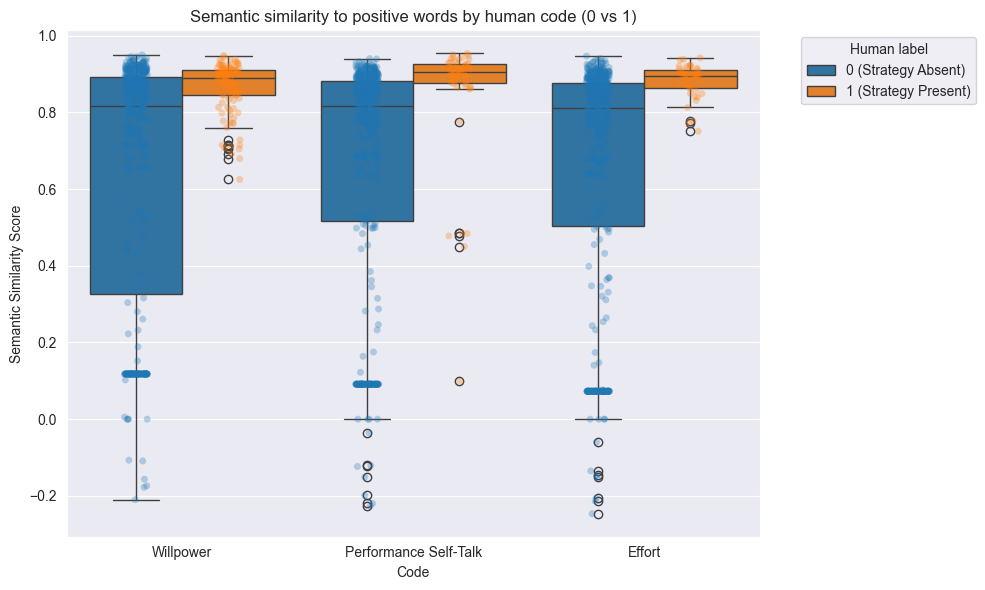

In [77]:
# Visualize the results of t-test
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rows = []

for code in codes:   # codes variable is defined above: ['Willpower','Performance Self-Talk','Effort']
    # similarity scores for this code (Series)
    sims = similarity_results[code]['sim_scores']   # from spacy_similarity_for_code

    # corresponding human labels (0/1) from text_df_filtered
    labels_raw = pd.to_numeric(text_df_filtered.loc[sims.index, code], errors="coerce")

    # keep only rows with valid 0/1 labels
    valid_mask = labels_raw.isin([0, 1])
    sims_use   = sims[valid_mask]
    labels_use = labels_raw[valid_mask].astype(int)

    # collect into long format
    for idx in sims_use.index:
        rows.append({
            "code": code,
            "label": labels_use.loc[idx],
            "similarity": sims_use.loc[idx]
        })

plot_df = pd.DataFrame(rows)

# Human-readable label text
plot_df["label_str"] = plot_df["label"].map({0: "0 (Strategy Absent)", 1: "1 (Strategy Present)"})

plt.figure(figsize=(10, 6))

ax = sns.boxplot(
    data=plot_df, x="code", y="similarity", hue="label_str"
)
sns.stripplot(
    data=plot_df, x="code", y="similarity", hue="label_str",
    dodge=True, alpha=0.3, linewidth=0, ax=ax
)

# Fix duplicate legends from boxplot + stripplot
handles, labels = ax.get_legend_handles_labels()
# First two entries correspond to the two label levels
ax.legend(handles[:2], labels[:2], title="Human Coding",
          bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("Semantic similarity to positive words by human code (0 vs 1)")
plt.ylabel("Semantic Similarity Score")
plt.xlabel("Code")
plt.tight_layout()
plt.show()
